In [1]:
# Text text processing library
import torchtext
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import itertools as it
from models import *
from helpers import *
# import main
import matplotlib.pyplot as plt
import spacy
import time
MAX_LEN = 20
MIN_FREQ = 5

In [2]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

BOS_WORD = '<s>'
EOS_WORD = '</s>'
DE = data.Field(tokenize=tokenize_de)

# only target needs BOS/EOS:
EN = data.Field(tokenize=tokenize_en, init_token = BOS_WORD, eos_token = EOS_WORD) 

train, val, test = datasets.IWSLT.splits(exts=('.de', '.en'), fields=(DE, EN), 
                                         filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
                                         len(vars(x)['trg']) <= MAX_LEN)

In [3]:
DE.build_vocab(train.src, min_freq=MIN_FREQ)
EN.build_vocab(train.trg, min_freq=MIN_FREQ)

pred_set = []
for i, line in enumerate(open("source_test.txt"), 1):
    words = line.split()
    pred_set.append([DE.vocab.stoi[s] for s in words])

train_iter, val_iter, test_iter = data.BucketIterator.splits((train, val, test), batch_size=32, device=-1,
                                                  repeat=False, sort_key=lambda x: len(x.src))

In [4]:
batch = next(iter(test_iter))
# sent_inspect(batch,4)
def sent_inspect(batch, idx=0):
    print("Source")
    print(' '.join([DE.vocab.itos[w] for w in batch.src.data[:,idx]]))
    print("Target")
    print(' '.join([EN.vocab.itos[w] for w in batch.trg.data[:,idx]]))
# print(DE.vocab.stoi['<pad>'])

In [ ]:
train_iter, val_iter = data.BucketIterator.splits((train, val), batch_size=32, device=-1,
                                                  repeat=False, sort_key=lambda x: len(x.src))
bs_encoder = BaseEncoder(DE, hidden_size=500, num_layers=4, word_features=500)
bs_decoder = BaseDecoder(EN, hidden_size=500, num_layers=4, word_features=500)
trainer = NMTTrainer([bs_encoder, bs_decoder], DE, EN, lrn_rate=0.7, 
                     lrn_decay='adaptive', reverse_enc_input=False)
evaluator = NMTEvaluator([bs_encoder, bs_decoder], DE, EN, reverse_enc_input=False)
trainer.train(train_iter, verbose=True, le=evaluator, val_iter=val_iter)

Target padding token: 1
Using CUDA...
Target padding token: 1
Using CUDA...
Epoch 0, loss: 68.804482, norm: 4.713892, elapsed: 480.698272, lrn_rate: 0.700000
Validation time: 0.752825 seconds
Validation set metric: 14.507076
Epoch 1, loss: 64.434280, norm: 5.689084, elapsed: 963.759561, lrn_rate: 0.700000
Validation time: 0.738729 seconds
Validation set metric: 10.272312
Epoch 2, loss: 56.084084, norm: 6.996671, elapsed: 1447.112933, lrn_rate: 0.700000
Validation time: 0.718113 seconds
Validation set metric: 8.533530
Epoch 3, loss: 39.182854, norm: 5.212823, elapsed: 1931.421803, lrn_rate: 0.700000
Validation time: 0.716954 seconds
Validation set metric: 7.516261
Epoch 4, loss: 46.313068, norm: 7.776521, elapsed: 2415.209798, lrn_rate: 0.700000
Validation time: 0.717423 seconds
Validation set metric: 7.031395
Epoch 5, loss: 40.980598, norm: 6.899519, elapsed: 2899.272682, lrn_rate: 0.700000
Validation time: 0.720704 seconds
Validation set metric: 6.896355
Epoch 6, loss: 42.708160, norm

Target padding token: 1
Using CUDA...
Target padding token: 1
Using CUDA...
Epoch 0, loss: 76.887482, norm: 3.609570, elapsed: 434.039064, lrn_rate: 1.000000


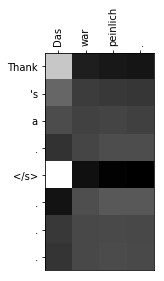

/home/jesse/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:179: DeprecationWarning: generator 'Iterator.__iter__' raised StopIteration


Validation time: 0.800610 seconds
Validation set metric: 20.379318
Epoch 1, loss: 72.301262, norm: 4.776157, elapsed: 871.258275, lrn_rate: 1.000000


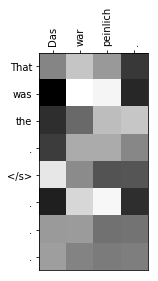

Validation time: 0.647401 seconds
Validation set metric: 13.198767
Epoch 2, loss: 58.776184, norm: 6.437706, elapsed: 1306.814696, lrn_rate: 1.000000


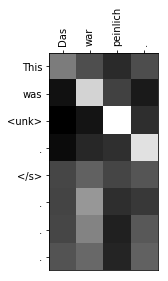

Validation time: 0.657315 seconds
Validation set metric: 8.312986
Epoch 3, loss: 42.573357, norm: 4.839356, elapsed: 1742.663088, lrn_rate: 1.000000


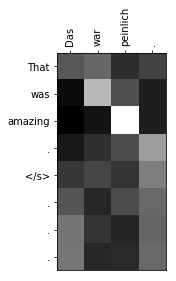

Validation time: 0.650553 seconds
Validation set metric: 6.945588
Epoch 4, loss: 48.475578, norm: 6.776090, elapsed: 2180.206217, lrn_rate: 1.000000


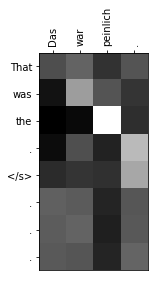

Validation time: 0.666383 seconds
Validation set metric: 6.127568
Epoch 5, loss: 44.011482, norm: 5.648389, elapsed: 2616.216526, lrn_rate: 1.000000


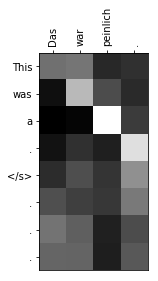

Validation time: 0.635444 seconds
Validation set metric: 5.800558
Epoch 6, loss: 46.449783, norm: 6.326534, elapsed: 3053.460636, lrn_rate: 1.000000


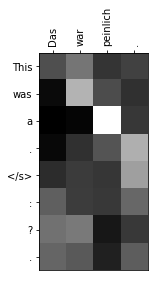

Validation time: 0.652206 seconds
Validation set metric: 5.535517
Epoch 7, loss: 43.174461, norm: 7.421712, elapsed: 3489.806428, lrn_rate: 1.000000


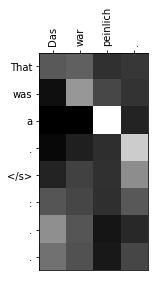

Validation time: 0.642426 seconds
Validation set metric: 5.489644
Epoch 8, loss: 44.182285, norm: 6.502578, elapsed: 3926.368750, lrn_rate: 1.000000


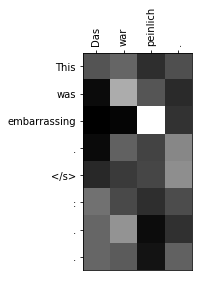

Validation time: 0.641979 seconds
Validation set metric: 5.385298
Epoch 9, loss: 40.999336, norm: 6.514516, elapsed: 4363.771027, lrn_rate: 1.000000


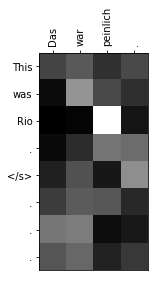

Validation time: 0.645812 seconds
Validation set metric: 5.267496
Epoch 10, loss: 34.245327, norm: 7.191163, elapsed: 4800.444866, lrn_rate: 1.000000


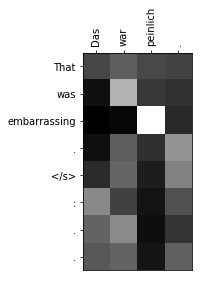

Validation time: 0.653332 seconds
Validation set metric: 5.263494
Epoch 11, loss: 40.374687, norm: 6.874678, elapsed: 5237.519108, lrn_rate: 1.000000


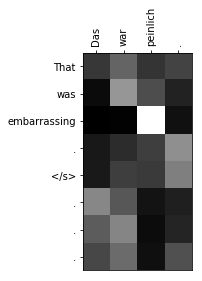

Validation time: 0.640162 seconds
Validation set metric: 5.205148
Epoch 12, loss: 33.773323, norm: 7.691394, elapsed: 5675.684035, lrn_rate: 1.000000


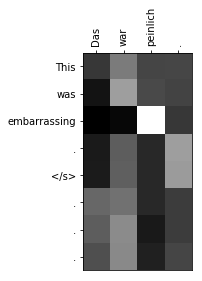

Validation time: 0.655494 seconds
Validation set metric: 5.326247
Decaying LR to 0.500000
Epoch 13, loss: 36.601433, norm: 7.964255, elapsed: 6112.606103, lrn_rate: 0.500000


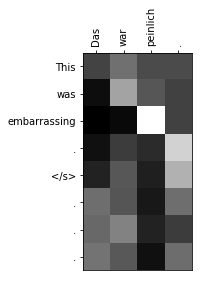

Validation time: 0.632024 seconds
Validation set metric: 5.059687
Epoch 14, loss: 33.005260, norm: 7.820327, elapsed: 6548.040974, lrn_rate: 0.500000


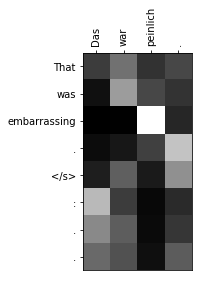

Validation time: 0.667436 seconds
Validation set metric: 5.101067
Decaying LR to 0.250000
Epoch 15, loss: 27.118631, norm: 7.310196, elapsed: 6985.036899, lrn_rate: 0.250000


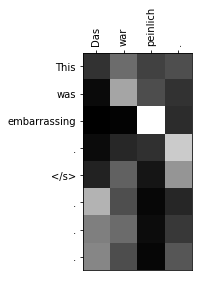

Validation time: 0.652261 seconds
Validation set metric: 5.069803
Epoch 16, loss: 21.960884, norm: 6.124631, elapsed: 7422.010813, lrn_rate: 0.250000


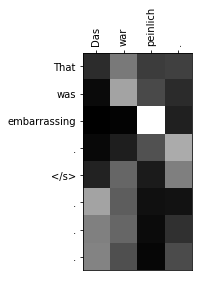

Validation time: 0.672074 seconds
Validation set metric: 5.096906
Decaying LR to 0.125000
Epoch 17, loss: 25.090322, norm: 7.710245, elapsed: 7858.233388, lrn_rate: 0.125000


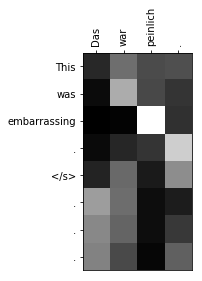

Validation time: 1.084133 seconds
Validation set metric: 5.105373
Decaying LR to 0.062500
Epoch 18, loss: 23.023893, norm: 7.680255, elapsed: 8294.389842, lrn_rate: 0.062500


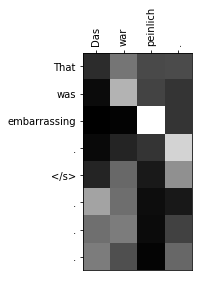

Validation time: 0.637478 seconds
Validation set metric: 5.125178
Decaying LR to 0.031250
Epoch 19, loss: 23.474609, norm: 6.863279, elapsed: 8728.711240, lrn_rate: 0.031250


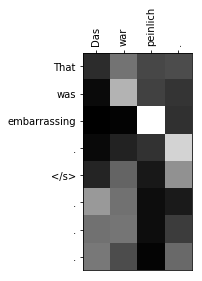

Validation time: 0.647996 seconds
Validation set metric: 5.159121
Decaying LR to 0.015625
Epoch 20, loss: 23.000750, norm: 6.774673, elapsed: 9164.156932, lrn_rate: 0.015625


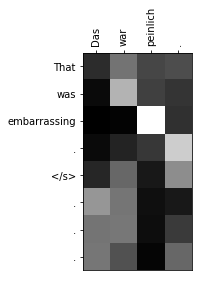

Validation time: 0.661088 seconds
Validation set metric: 5.163196
Decaying LR to 0.007812
Epoch 21, loss: 22.243795, norm: 6.222689, elapsed: 9599.884425, lrn_rate: 0.007812


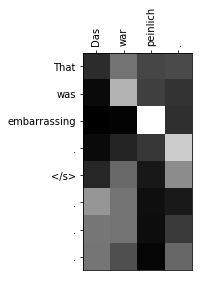

Validation time: 0.637119 seconds
Validation set metric: 5.170865
Decaying LR to 0.003906
Epoch 22, loss: 23.586414, norm: 7.828342, elapsed: 10033.957072, lrn_rate: 0.003906


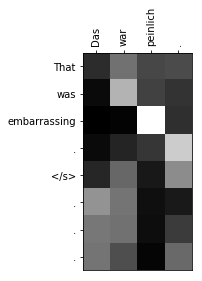

Validation time: 0.640627 seconds
Validation set metric: 5.175405
Decaying LR to 0.001953


KeyboardInterrupt: 

In [80]:
train_iter, val_iter = data.BucketIterator.splits((train, val), batch_size=32, device=-1,
                                                  repeat=False, sort_key=lambda x: len(x.src))
bs_encoder = BaseEncoder(DE, hidden_size=500, num_layers=4, word_features=500, dropout=0.2)
# TODO: decide whether to add dropout to output states of encoder!
bs_decoder = AttnDecoder(EN, hidden_size=500, num_layers=4, word_features=500, dropout=0.2)
trainer = NMTTrainer([bs_encoder, bs_decoder], DE, EN, lrn_rate=1.0, 
                     lrn_decay='adaptive', attention=True)
evaluator = NMTEvaluator([bs_encoder, bs_decoder], DE, EN, attention=True,
                        record_attention=True, visualize_freq=50)
trainer.train(train_iter, verbose=True, le=evaluator, val_iter=val_iter)

Target padding token: 1
Using CUDA...
Target padding token: 1
Using CUDA...
Epoch 0, loss: 76.417343, norm: 4.094759, elapsed: 398.931221, lrn_rate: 1.000000


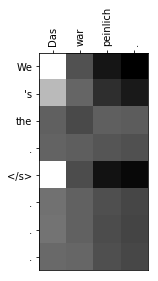

Validation time: 0.897022 seconds
Validation set metric: 19.849259
Epoch 1, loss: 56.872398, norm: 4.433528, elapsed: 800.701381, lrn_rate: 1.000000


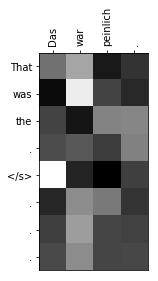

Validation time: 0.578980 seconds
Validation set metric: 12.444824
Epoch 2, loss: 61.455700, norm: 5.653407, elapsed: 1202.571866, lrn_rate: 1.000000


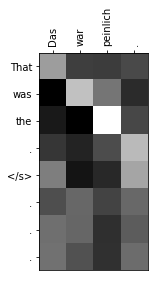

Validation time: 0.579076 seconds
Validation set metric: 8.742749
Epoch 3, loss: 53.114815, norm: 5.385357, elapsed: 1603.678376, lrn_rate: 1.000000


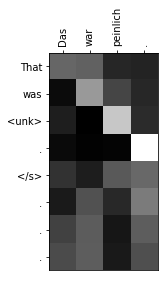

Validation time: 0.576955 seconds
Validation set metric: 7.343770
Epoch 4, loss: 58.102104, norm: 5.962880, elapsed: 2005.145587, lrn_rate: 1.000000


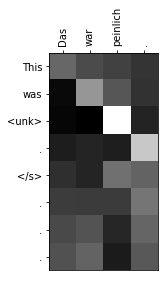

Validation time: 0.574288 seconds
Validation set metric: 6.672210
Epoch 5, loss: 50.359871, norm: 5.670688, elapsed: 2405.971008, lrn_rate: 1.000000


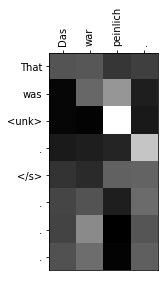

Validation time: 0.583137 seconds
Validation set metric: 6.205138
Epoch 16, loss: 36.860390, norm: 6.084704, elapsed: 6822.325762, lrn_rate: 0.007812


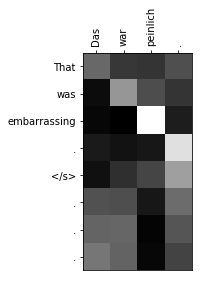

Validation time: 0.568601 seconds
Validation set metric: 4.931105
Decaying LR to 0.003906
Epoch 20, loss: 36.994865, norm: 5.987509, elapsed: 8430.183001, lrn_rate: 0.000488


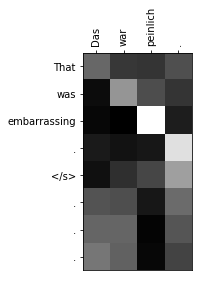

Validation time: 0.583046 seconds
Validation set metric: 4.931669
Decaying LR to 0.000244
Epoch 21, loss: 37.163670, norm: 5.719991, elapsed: 8833.623228, lrn_rate: 0.000244


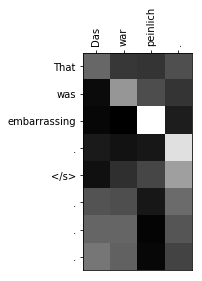

Validation time: 0.594749 seconds
Validation set metric: 4.931758
Decaying LR to 0.000122
Epoch 22, loss: 42.002277, norm: 6.247498, elapsed: 9235.134458, lrn_rate: 0.000122


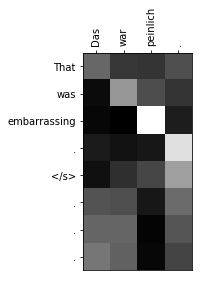

Validation time: 0.572117 seconds
Validation set metric: 4.931683
Decaying LR to 0.000061
Epoch 23, loss: 40.986053, norm: 7.307539, elapsed: 9636.894778, lrn_rate: 0.000061


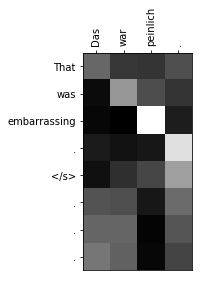

Validation time: 0.579088 seconds
Validation set metric: 4.931671
Decaying LR to 0.000031
Epoch 24, loss: 34.751427, norm: 5.901461, elapsed: 10038.890599, lrn_rate: 0.000031


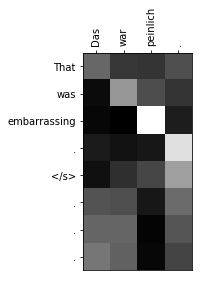

Validation time: 0.584518 seconds
Validation set metric: 4.931667
Decaying LR to 0.000015
Epoch 25, loss: 37.526859, norm: 5.783829, elapsed: 10439.440281, lrn_rate: 0.000015


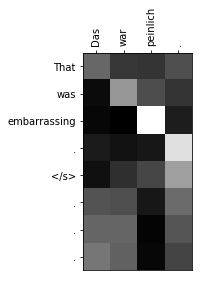

Validation time: 0.586059 seconds
Validation set metric: 4.931674
Decaying LR to 0.000008
Epoch 26, loss: 40.874893, norm: 7.661327, elapsed: 10839.351204, lrn_rate: 0.000008


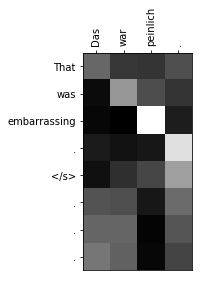

Validation time: 0.593650 seconds
Validation set metric: 4.931676
Decaying LR to 0.000004
Epoch 27, loss: 42.856510, norm: 7.495936, elapsed: 11239.255431, lrn_rate: 0.000004


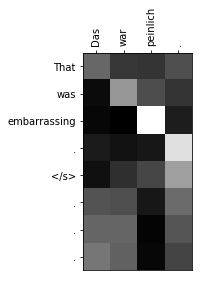

Validation time: 0.602010 seconds
Validation set metric: 4.931676
Decaying LR to 0.000002
Epoch 28, loss: 38.012066, norm: 5.993013, elapsed: 11640.766380, lrn_rate: 0.000002


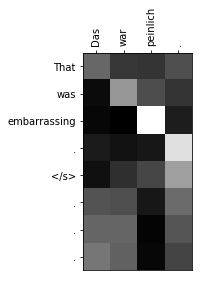

Validation time: 0.582824 seconds
Validation set metric: 4.931676
Decaying LR to 0.000001
Epoch 29, loss: 39.289017, norm: 7.428113, elapsed: 12040.793742, lrn_rate: 0.000001


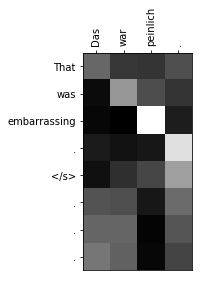

Validation time: 0.573764 seconds
Validation set metric: 4.931676
Decaying LR to 0.000000
Epoch 30, loss: 39.035702, norm: 7.196814, elapsed: 12441.495830, lrn_rate: 0.000000


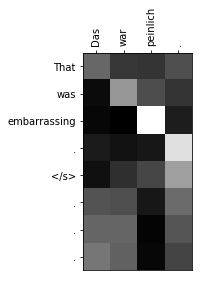

Validation time: 0.644286 seconds
Validation set metric: 4.931676
Decaying LR to 0.000000


In [ ]:
train_iter, val_iter = data.BucketIterator.splits((train, val), batch_size=32, device=-1,
                                                  repeat=False, sort_key=lambda x: len(x.src))
bs_encoder = BaseEncoder(DE, hidden_size=450, num_layers=4, word_features=450, dropout=0.4)
# TODO: decide whether to add dropout to output states of encoder!
bs_decoder = AttnDecoder(EN, hidden_size=450, num_layers=4, word_features=450, dropout=0.4)
trainer = NMTTrainer([bs_encoder, bs_decoder], DE, EN, lrn_rate=1.0, 
                     lrn_decay='adaptive', attention=True)
evaluator = NMTEvaluator([bs_encoder, bs_decoder], DE, EN, attention=True,
                        record_attention=True, visualize_freq=50)
trainer.train(train_iter, verbose=True, le=evaluator, val_iter=val_iter)

In [12]:
evaluator.record_attention = False
evaluator.predict(pred_set, fn='predictions_jesse.txt',beam_size=100)

torch.Size([1156000])
torch.Size([1156000])
Writing predictions to predictions_jesse.txt...
Computing predictions took 56.911393 seconds


In [10]:
for i in range(10):
    print(' '.join(DE.vocab.itos[w] for w in debug_set[i]))
    print(' '.join(EN.vocab.itos[w] for w in debug_ans[i]))    

NameError: name 'debug_set' is not defined

In [74]:
print(evaluator.evaluate(val_iter))
print(len(train_iter))
sample = evaluator.attns_log[0]
attn = sample[0][7].cpu().data.numpy()
src_words = np.array(list(map(lambda x: DE.vocab.itos[x], sample[1][7].cpu().data.numpy())))
pred_words = np.array(list(map(lambda x: EN.vocab.itos[x], sample[2][7].cpu().data.numpy())))
print(attn, src_words, pred_words)
val_iter.init_epoch()
batch = next(iter(val_iter))
sent_inspect(batch, 4)

Validation time: 0.227288 seconds
44.62296943611147
3722
[[0.3444936  0.21377848 0.22162947 0.22009845]
 [0.26543933 0.24090041 0.24601129 0.24764895]
 [0.26933482 0.24343687 0.24473654 0.24249181]
 [0.23431073 0.25176635 0.2556089  0.25831398]
 [0.24062863 0.25227922 0.25303474 0.25405735]
 [0.23847908 0.25292277 0.25366053 0.2549376 ]
 [0.23905838 0.2531099  0.25337002 0.2544617 ]
 [0.23879042 0.2531038  0.25345555 0.25465024]] ['Ich' 'war' 'verzweifelt' '.'] ['And' "'s" '.' '.' '</s>' '</s>' '</s>' '</s>']
Source
Ich hatte Angst –
Target
<s> And I was scared . </s> <pad> <pad>


/home/jesse/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:162: DeprecationWarning: generator 'Iterator.__iter__' raised StopIteration


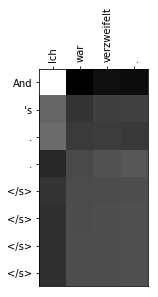

In [76]:
fig, ax = plt.subplots()

ax.imshow(attn, cmap='gray')
plt.xticks(range(len(src_words)),src_words, rotation='vertical')
plt.yticks(range(len(pred_words)),pred_words)
ax.xaxis.tick_top()
plt.show()

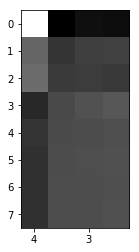

In [63]:
fig, ax = plt.subplots(1,1)
ax.imshow(attn, cmap='gray')
ax.set_xticklabels(['i', '4', '3', '1'])
plt.show()

In [127]:
print(EN.vocab.stoi['<s>'])
print(EN.vocab.itos[2])

2
<s>


In [23]:
# evaluator = NMTEvaluator([bs_encoder, bs_decoder], DE, EN, reverse_enc_input=False)
evaluator = NMTEvaluator([bs_encoder, bs_decoder], DE, EN, attention=True,
                        record_attention=True)
print(evaluator.evaluate(test_iter))
print(evaluator.evaluate(val_iter))
test_iter.init_epoch()
debug_iter = iter(test_iter)
for i in range(10):
    batch = next(debug_iter)
debug_set = [batch.src.data[:, i] for i in range(batch.src.data.size(1))]
debug_ans = [batch.trg.data[:, i] for i in range(batch.trg.data.size(1))]
evaluator.predict(pred_set, fn='predictions.txt',beam_size=100)

Target padding token: 1
Using CUDA...


RuntimeError: cat(): argument 'tensors' (position 1) must be tuple of Variables, not Variable

## OLD STUFF BELOW HERE